In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [3]:
dataset = data.load_dataset()
relations_by_name = {r.name: r for r in dataset.relations}

In [4]:
from typing import Literal
import pandas as pd

def segregate_table_results_categorywise(
    results_df: pd.DataFrame | dict,
    property_key: Literal["relation_type", "fn_type", "disambiguating", "symmetric"] = "relation_type",
    metric: Literal["efficacy", "recall@1"] = "efficacy"
) -> dict:
    if isinstance(results_df, pd.DataFrame):
        results_df = {relation["relation"]:relation for relation in results_df.to_dict(orient="records")}

    # performance_category_wise = {k: {} for k in ["factual", "linguistic", "commonsense", "bias"]}
    performance_category_wise = {}
    for relation_name in results_df.keys():
        property_value = relations_by_name[relation_name].properties.__dict__[property_key]
        result = results_df[relation_name]
        if property_value not in performance_category_wise:
            performance_category_wise[property_value] = []
        performance_category_wise[property_value].append(float(result[metric].split()[0]))

    for property_value in performance_category_wise:
        performance_category_wise[property_value] = np.array(performance_category_wise[property_value]).mean(axis = 0)
    
    return performance_category_wise

In [5]:
table_path = "../../results/tables"

MODELS = [
    "gpt2-xl", 
    "gptj", 
    "llama-13b"
]
categorywise_results = {k : {} for k in ["factual", "linguistic", "commonsense", "bias"]}

for model_name in MODELS:
    df = pd.read_csv(f"{table_path}/{model_name}-hparams.csv")
    model_results = segregate_table_results_categorywise(
        df, 
        property_key = "relation_type", 
        metric = "efficacy"
    )

    for category in categorywise_results:
        categorywise_results[category][model_name] = model_results[category]

categorywise_results

{'factual': {'gpt2-xl': 0.65125,
  'gptj': 0.7136000000000001,
  'llama-13b': 0.6608695652173914},
 'linguistic': {'gpt2-xl': 0.815,
  'gptj': 0.9166666666666666,
  'llama-13b': 0.8716666666666667},
 'commonsense': {'gpt2-xl': 0.82,
  'gptj': 0.8825000000000001,
  'llama-13b': 0.67875},
 'bias': {'gpt2-xl': 0.8775, 'gptj': 0.9614285714285715, 'llama-13b': 0.955}}

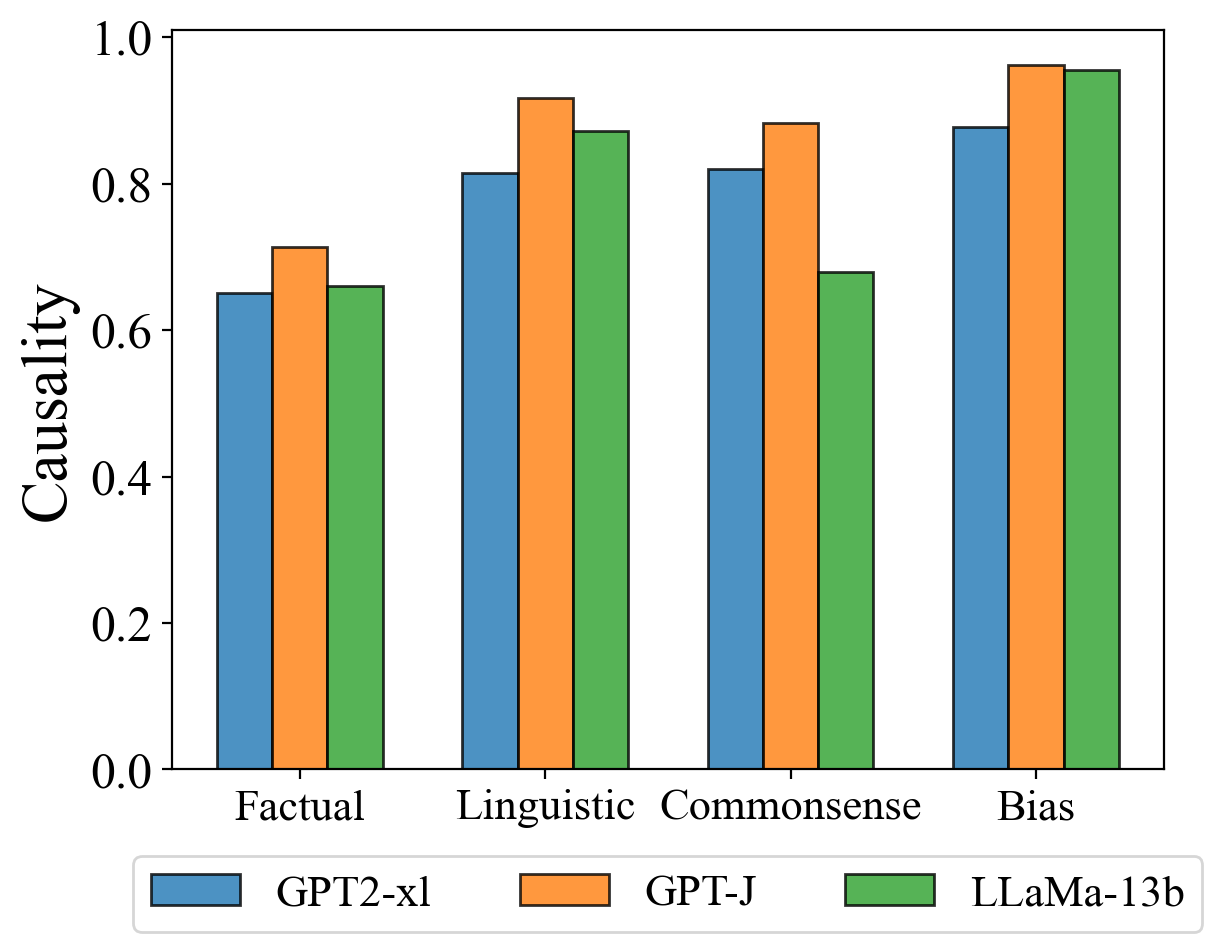

In [6]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################


n_subplots = len(categorywise_results)
ncols=n_subplots
nrows=int(np.ceil(n_subplots / ncols))

category_order = ["factual", "linguistic", "commonsense", "bias"]
models = {
    "gpt2-xl": "GPT2-xl", 
    "gptj": "GPT-J", 
    "llama-13b": "LLaMa-13b"
}

idx = 0
bar_width = 0.225
for model in models:
    recalls = []
    for category in category_order:
        recalls.append(categorywise_results[category][model])
    
    plt.bar(
        np.arange(len(recalls)) + idx * bar_width, recalls,
        width = bar_width,
        label = models[model],
        edgecolor = "black",
        alpha = 0.8
    )
    idx += 1

plt.xticks(np.arange(len(recalls)) + bar_width, [cat.capitalize() for cat in category_order])
plt.ylabel("Causality")
plt.legend(ncol = 3, bbox_to_anchor=(0.5, -.25), loc='lower center')
plt.savefig(f"figs/efficacy_lre_models.pdf", bbox_inches="tight")
plt.show()

In [7]:
from src.utils.sweep_utils import read_efficacy_baseline_results, format_efficacy_baseline_results
############################################
efficacy_root = "../../results/efficacy_baselines-24-trials"
############################################""

efficacy_path = f"{efficacy_root}/gptj"

In [8]:
efficacy_results_raw = read_efficacy_baseline_results(efficacy_path)
list(efficacy_results_raw.keys())

['adjective antonym',
 'country capital city',
 'plays pro sport',
 'person plays instrument',
 'person university',
 'city in country',
 'food from country',
 'occupation gender',
 'occupation age',
 'name gender',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'president election year',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'person lead singer of band',
 'task person type',
 'characteristic gender',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'pokemon evolution',
 'president birth year',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'company CEO',
 'superhero person',
 'substance phase of matter',
 'adjective superlative',
 'adjective comparative']

In [9]:
efficacy_results = {
    relation_name: format_efficacy_baseline_results(efficacy_result)
    for relation_name, efficacy_result in efficacy_results_raw.items()
}

In [10]:
hparam_table = pd.read_csv("../../results/tables/gptj-hparams.csv")
hparam_table[hparam_table["relation"] == "country capital city"]["layer"].values[0]

'3'

In [11]:
from typing import Literal

def segregate_categorywise(
    results_formatted: dict,
    hparam_table: pd.DataFrame,
    property_key: Literal["relation_type", "fn_type", "disambiguating", "symmetric"] = "relation_type"
) -> dict:
    performance_category_wise = {}
    for relation_name in results_formatted:
        layer = hparam_table[hparam_table["relation"] == relation_name]["layer"].values[0]
        layer = int(layer) if layer != "emb" else layer
        property_value = relations_by_name[relation_name].properties.__dict__[property_key]
        efficacy_result = results_formatted[relation_name]["layerwise_result"][layer]
        if property_value not in performance_category_wise:
            performance_category_wise[property_value] = {}

        for edit_type in efficacy_result:
            if edit_type not in performance_category_wise[property_value]:
                performance_category_wise[property_value][edit_type] = []
            performance_category_wise[property_value][edit_type].append(efficacy_result[edit_type].mean)
        

    for property_value in performance_category_wise:
        for edit_type in performance_category_wise[property_value]:
            performance_category_wise[property_value][edit_type] = np.array(performance_category_wise[property_value][edit_type]).mean(axis = 0)
    
    return performance_category_wise

In [12]:
efficacy_category_wise = segregate_categorywise(
    efficacy_results, 
    hparam_table=hparam_table
)

efficacy_category_wise

{'linguistic': {'hidden_baseline': 0.8676400937373266,
  'embed_baseline': 0.02741062785313958,
  'low_rank_pinv': 0.9187740723345796,
  'hidden_baseline_z': 0.015869165445135797},
 'factual': {'hidden_baseline': 0.7562028682071239,
  'embed_baseline': 0.22900068116212596,
  'low_rank_pinv': 0.7871568867062402,
  'hidden_baseline_z': 0.13897992538431914},
 'bias': {'hidden_baseline': 0.8134259401374339,
  'embed_baseline': 0.41529382021765704,
  'low_rank_pinv': 0.9757075362443333,
  'hidden_baseline_z': 0.29985988519254125},
 'commonsense': {'hidden_baseline': 0.7967123341268005,
  'embed_baseline': 0.3307687544580103,
  'low_rank_pinv': 0.8837146903884838,
  'hidden_baseline_z': 0.1250198507028394}}

In [18]:
category_order = ['factual', 'linguistic', 'bias', 'commonsense']
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 35+5
MEDIUM_SIZE = 50
BIGGER_SIZE = 55+5

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

edit_type_legends = {
    "low_rank_pinv": "Causality",
    "hidden_baseline"   : "Replacing with s′",
    "embed_baseline"    : "Replacing with e",
    "hidden_baseline_z" : "Replacing with o′"
}

color_dict = {
    "low_rank_pinv": "darkorange",
    "hidden_baseline": "darkgreen",
    "embed_baseline": "darkred",
    "hidden_baseline_z": "blue"
}

edit_types = ["low_rank_pinv", "hidden_baseline", "embed_baseline", "hidden_baseline_z"][::-1]

#####################################################################################


def plot_categorywise(canvas, result, title, set_yticks = True):
    bar_width = 0.8
    idx = 0

    causality_scores = [result[edit] for edit in edit_types]
    canvas.barh(
        np.arange(len(recalls)), causality_scores, 
        height = bar_width,
        color = "darkorange", #[color_dict[edit] for edit in edit_types],
        edgecolor = "black", linewidth = 2,
        alpha = 0.65
    )    
    canvas.set_xlim(0, 1)
    canvas.set_title(title.capitalize(), fontsize = BIGGER_SIZE)

    canvas.set_yticks(np.arange(len(edit_types)))
    if set_yticks:
        canvas.set_yticklabels([edit_type_legends[edit] for edit in edit_types])
    else:
        canvas.set_yticklabels([""] * len(edit_types))
    canvas.set_xticks(np.linspace(0, 1, 5))        

/tmp/ipykernel_534931/2109786008.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


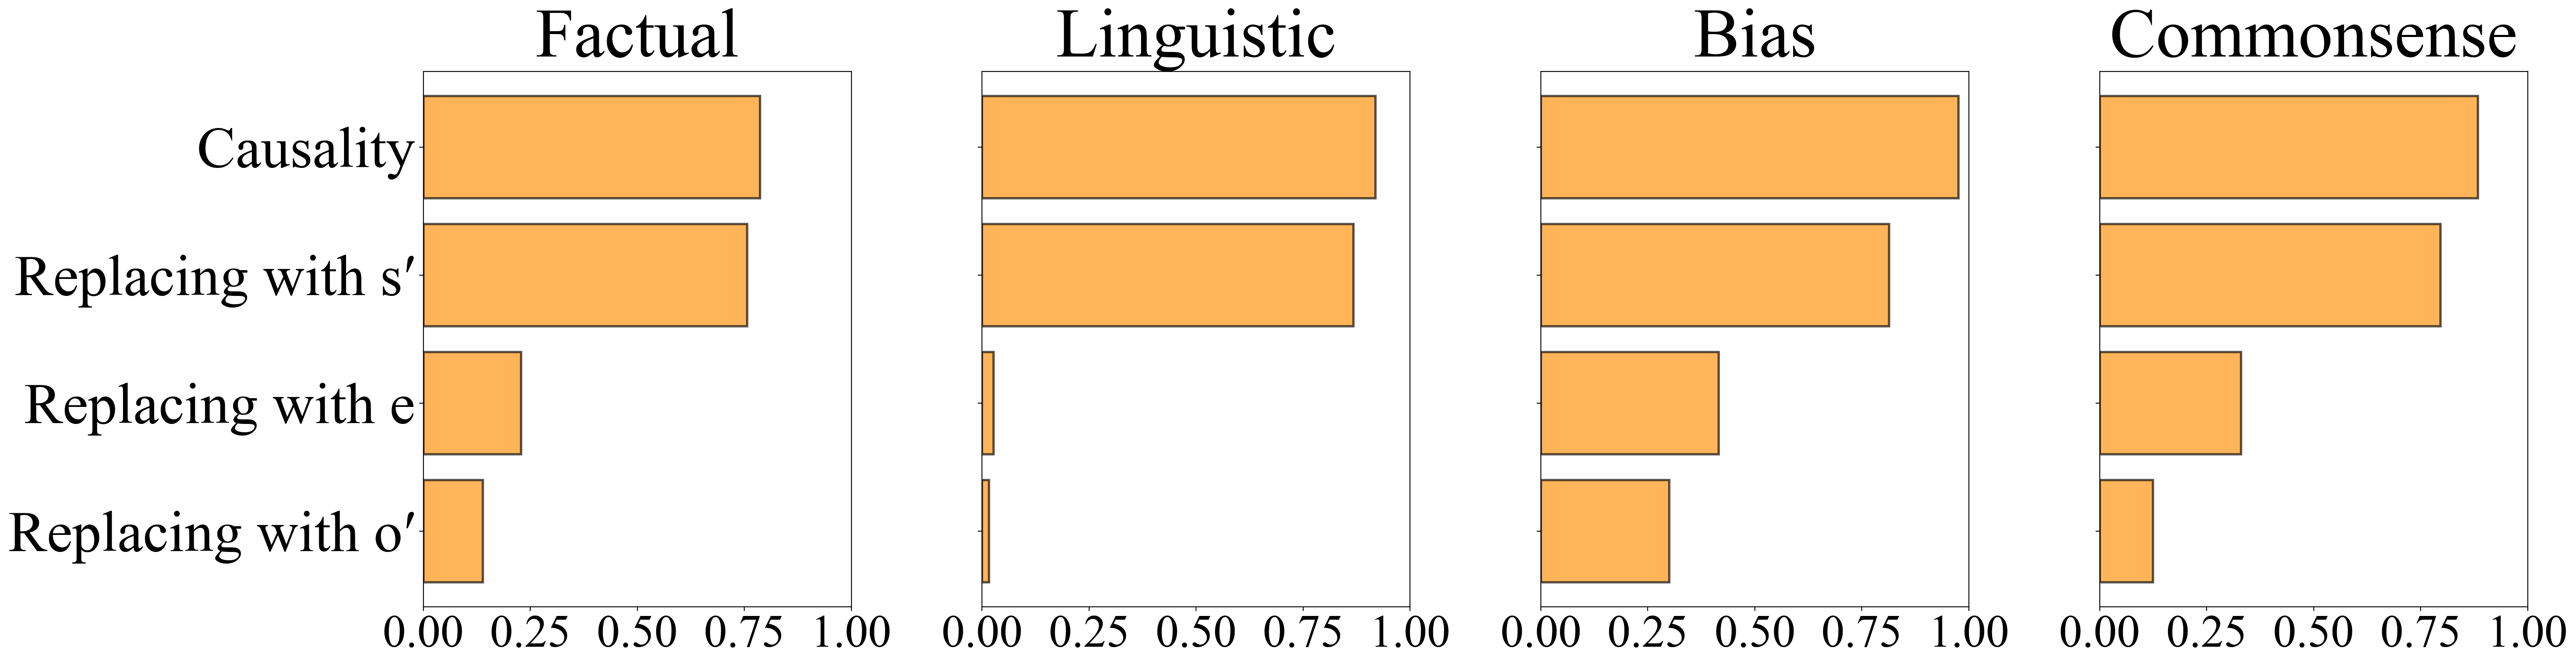

In [19]:
n_subplots = len(efficacy_category_wise)
ncols=4
nrows=int(np.ceil(n_subplots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 9))
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

ax_col, ax_row = 0, 0

for category in category_order:
    plot_categorywise(axes[ax_row][ax_col], efficacy_category_wise[category], category, set_yticks=ax_col == 0)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1

plt.savefig(f"figs/gptj/causality_baselines.pdf", bbox_inches="tight")
fig.tight_layout()
fig.show()

In [15]:
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

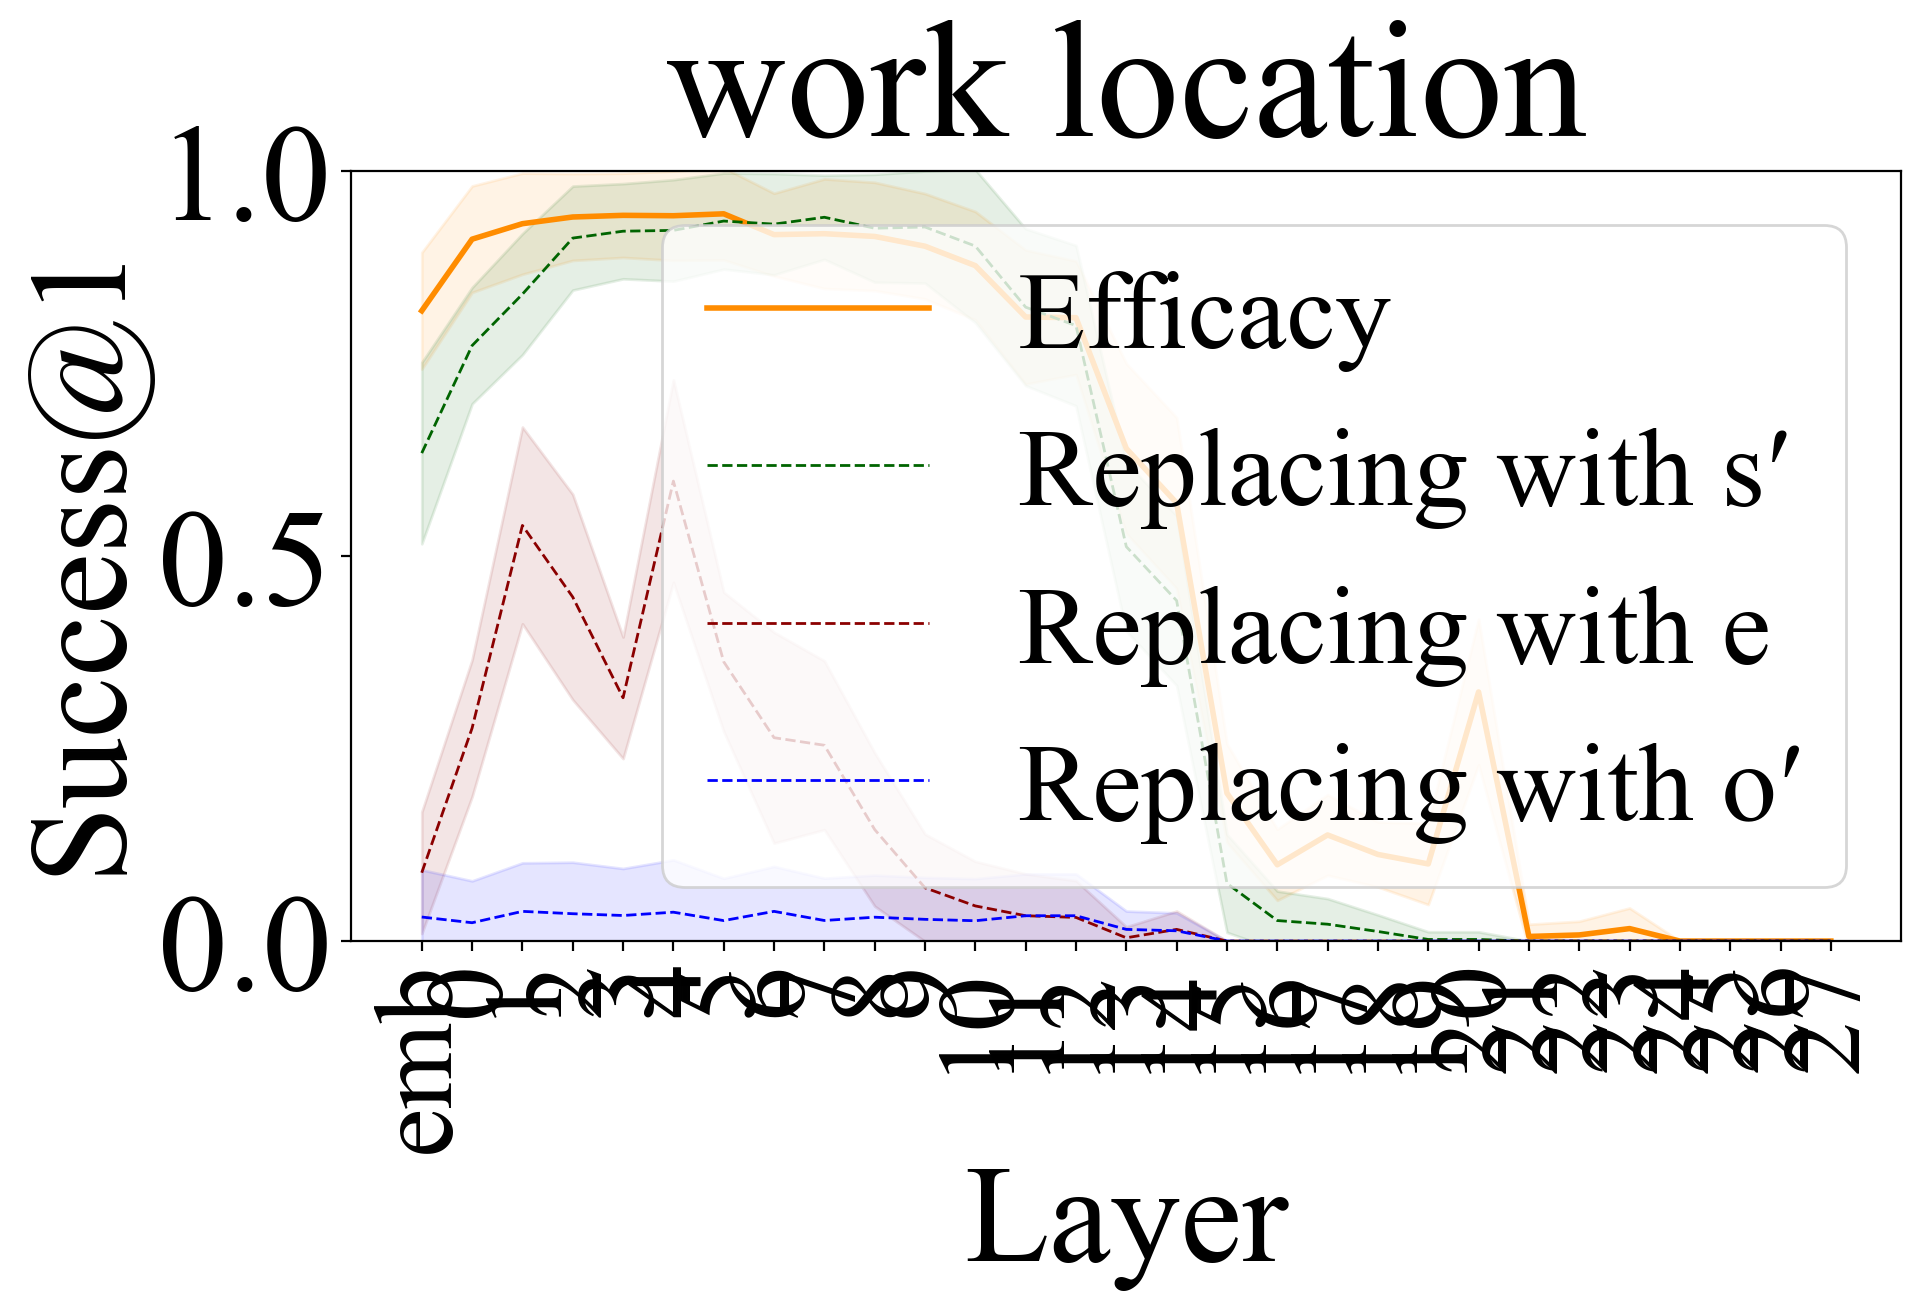

In [16]:
relation_name = "work location"
color_dict = {
    "low_rank_pinv": "darkorange",
    "hidden_baseline": "darkgreen",
    "embed_baseline": "darkred",
    "hidden_baseline_z": "blue"
}

edit_type_legends = {
    "low_rank_pinv": "Efficacy",
    "hidden_baseline"   : "Replacing with s′",
    "embed_baseline"    : "Replacing with e",
    "hidden_baseline_z" : "Replacing with o′"
}

def plot_efficacy_baseline(
        ax, efficacy_result, 
        show_legend = True,
        export_legend_to_file = None, 
    ):
    layerwise_result = efficacy_result["layerwise_result"]
    layers = list(layerwise_result.keys())
    # edit_types = list(layerwise_result[layers[0]].keys())
    edit_types = ["low_rank_pinv", "hidden_baseline", "embed_baseline", "hidden_baseline_z"]

    for edit_type in edit_types:
        if(edit_type not in color_dict):
            continue
        ax.plot(
            range(len(layers)),
            [layerwise_result[layer][edit_type].mean for layer in layers],
            label=edit_type_legends[edit_type],
            color=color_dict[edit_type],
            alpha=1,
            linestyle='--' if edit_type != "low_rank_pinv" else '-',
            linewidth=1 if edit_type != "low_rank_pinv" else 2
        )
        ax.fill_between(
            range(len(layers)),
            [layerwise_result[layer][edit_type].mean - layerwise_result[layer][edit_type].stdev for layer in layers],
            [layerwise_result[layer][edit_type].mean + layerwise_result[layer][edit_type].stdev for layer in layers],
            alpha=0.1,
            color=color_dict[edit_type]
        )
    ax.set_xticks(range(len(layers)), layers, rotation=90)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)
    if show_legend:
        ax.legend()
    if export_legend_to_file is not None:
        legend = ax.legend(
            ncol = len(edit_types), bbox_to_anchor=(4.7, -0.3), 
            frameon=False, fontsize=20
        )
        export_legend(legend, export_legend_to_file)
        legend.remove()

    ax.set_xlabel("Layer")
    ax.set_ylabel("Success@1")
    if(ax.get_title() == ""):
        ax.set_title(efficacy_result["relation_name"])



efficacy_result = format_efficacy_baseline_results(
    efficacy_results_raw[relation_name]
)

fig, ax = plt.subplots(figsize=(10, 5))
plot_efficacy_baseline(ax, efficacy_result)

work location <class 'matplotlib.axes._axes.Axes'>
task person type <class 'matplotlib.axes._axes.Axes'>
city in country <class 'matplotlib.axes._axes.Axes'>
person lead singer of band <class 'matplotlib.axes._axes.Axes'>


/tmp/ipykernel_534931/1709515717.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


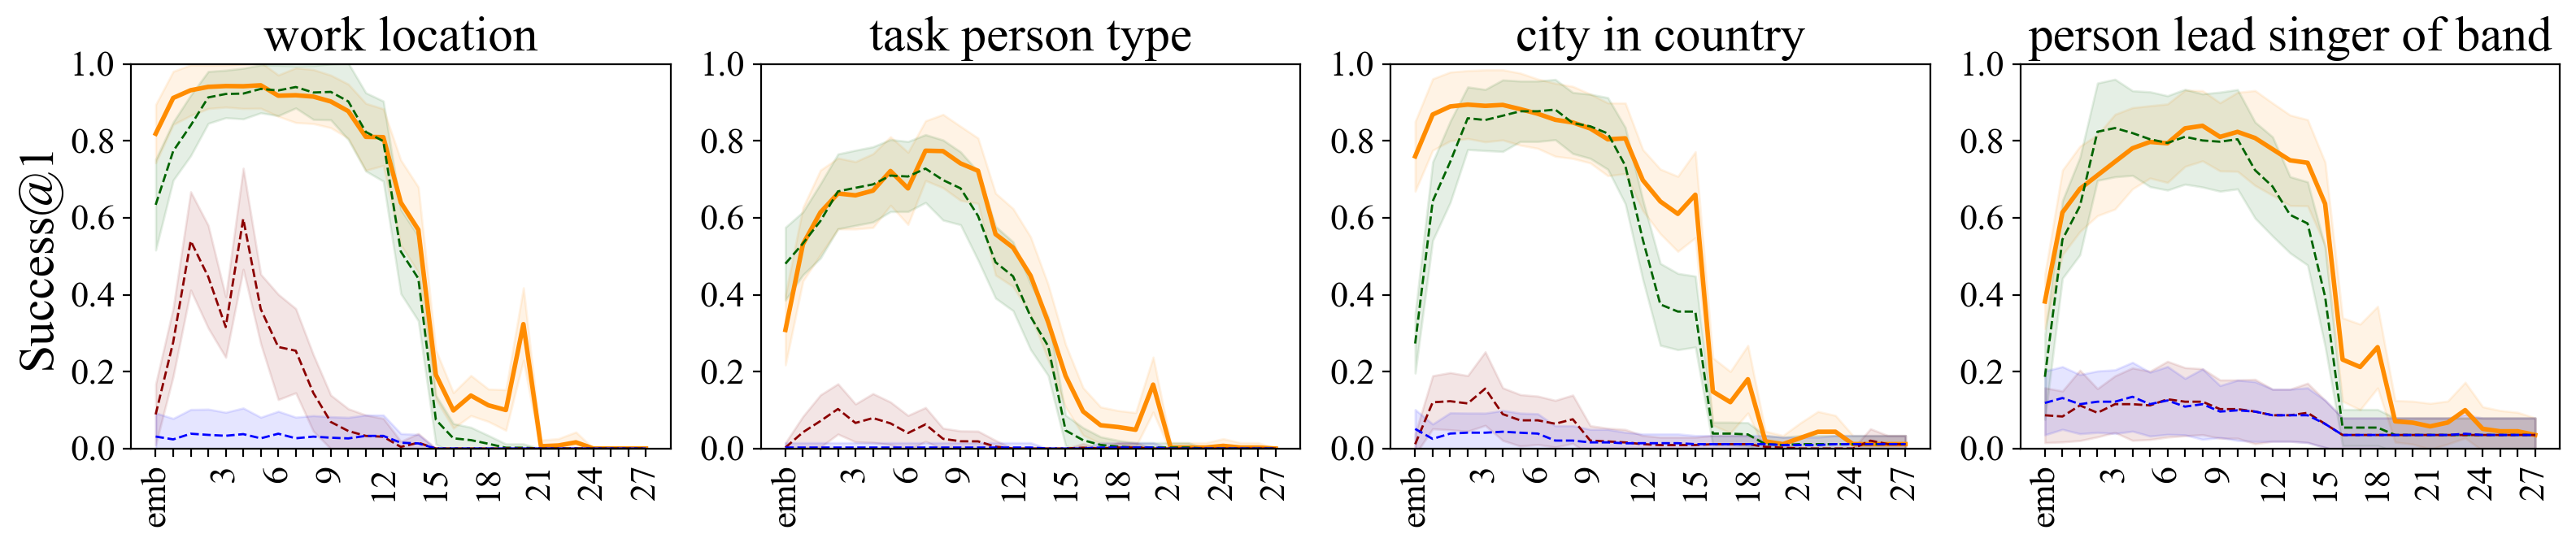

In [17]:
relation_names = [
    "work location", "task person type", "city in country", "person lead singer of band"
]

filtered_results = {}
for relation_name in relation_names:
    raw_result = efficacy_results_raw[relation_name] 
    filtered_results[relation_name] = format_efficacy_baseline_results(raw_result)

#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

n_cols = 4
n_rows = int(np.ceil(len(relation_names)/n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 3.5))

axes = [axes] if n_rows == 1 else axes
axes = [axes] if n_cols == 1 else axes

layers = list(efficacy_result["layerwise_result"].keys())
selected_layers = [layers[0]] + layers[1::3][1:]

layer_labels = []
for layer in layers:
    if layer in selected_layers:
        layer_labels.append(layer)
    else:
        layer_labels.append("")

cur_row = 0
cur_col = 0
for relation_name in relation_names:
    relation_result = filtered_results[relation_name]
    ax = axes[cur_row][cur_col]
    print(relation_name, type(ax))
    plot_efficacy_baseline(
        ax, filtered_results[relation_name], 
        show_legend=False, 
        export_legend_to_file="figs/gptj/legend-causality-baselines.pdf" if cur_col == 0 else None,
    )
    ax.set_title(relation_result['relation_name'], fontsize=BIGGER_SIZE)
    ax.set_xticks(range(len(layers)), layer_labels)
    if cur_col == 0:
        ax.set_ylabel("Success@1", fontsize=BIGGER_SIZE)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    cur_col += 1
    if cur_col == n_cols:
        cur_row += 1
        cur_col = 0


fig.tight_layout()
plt.savefig(f"figs/gptj/layer-wise-causality-baseline.pdf", bbox_inches="tight")

fig.show()